# run test on trained models for censored data

In [2]:
cd /home/makinen/repositories/fishnets/

/home/makinen/repositories/fishnets


In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
#import torch
import jax
from jax import lax
#import jax_cosmo as jc
import scipy.constants as cnst
import scipy.stats as ss

import matplotlib.pyplot as plt

import numpy as np
import numpyro
import numpyro.distributions as dist

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import trange
from scipy import stats
tfk = tf.keras

from fishnets import *

/softs/python/py3mods/tensorflow/2.8.4/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
n_data=10000 # for testing

In [5]:
def gamma_pop_model(key, theta, 
                    n_data=n_data, 
                    serum_min=0.2, 
                    tmax=10.,
                    A=500.0):

  population = jnp.zeros((n_data, 2))
  mean, scale = theta # shape, reporting delay
  rate = 1./ scale #concentration / report_delay
  concentration = mean / scale
  key,rng = jax.random.split(key)

  def fn(key):
    #data,key = data_tuple
    key,rng = jax.random.split(key)
    decay_time = dist.Gamma(concentration=concentration, 
                           rate=rate).sample(key, ())

    key,rng = jax.random.split(key)
    measurement_time = dist.Uniform(low=0.0, high=tmax).sample(key, ())

    key,rng = jax.random.split(key)
    _lambda = A * jnp.exp(-measurement_time / decay_time )
    measured_serum_level = dist.Poisson(rate=_lambda).sample(key, ())

    #measured_serum_level += dist.Normal(loc=0.0, scale=0.2).sample(key, ())

    return jnp.array([measurement_time, measured_serum_level]) #, key

  # vmap without censoring
  keys = jax.random.split(key, num=n_data)
  population = jax.vmap(fn)(keys)

  return population

In [11]:
n_sims = 1000

# theta = (concentration, rate)
# mean of Gamma = concentration / rate
key = jax.random.PRNGKey(34)
mean = dist.Uniform(low=0.5, high=10.).sample(key, (n_sims,))
key,rng = jax.random.split(key)
scale = dist.Uniform(low=0.1, high=1.5).sample(key, (n_sims,))


theta = jnp.vstack([mean, scale]).T

In [12]:
keys = jax.random.split(jax.random.PRNGKey(10), num=n_sims)
%time data = jax.vmap(gamma_pop_model)(keys, theta)

CPU times: user 197 ms, sys: 466 µs, total: 197 ms
Wall time: 192 ms


In [13]:
outdir = '/data80/makinen/fishnets/gamma_pop/data/'
np.save(outdir + 'data_uncensored_10k', data)
np.save(outdir + 'theta_uncensored_10k', theta)

In [10]:
data.shape

(1000, 10000, 2)

# load in pretrained model

In [8]:
outdir = '/data80/makinen/fishnets/gamma_pop/data/'

data = np.load(outdir + 'data_uncensored_10k.npy')

In [9]:
data.shape

(1000, 10000, 2)

In [20]:
# data = np.load(outdir + 'data_gamma_uncensored.npy')
# np.max(data[:, :, 1])

In [11]:
n_sims = 1000
n_data = 10000
n_theta = 2

datamax = 607. #np.max(data[:, :, 1])
datamin = 25. #np.min(data[:, :, 1])
tmax = 10.
#datamax = 592.

full_data = np.zeros((n_sims,n_data,2))
full_data[:, :, 0] = data[:, :, 0] / tmax
full_data[:, :, 1] = data[:, :, 1] / datamax
data = full_data; del full_data

In [15]:
tmax=10. # days
serum_max_val=4.0

theta_fid = tf.constant([5.0, 0.8], dtype=tf.float32) 
theta_fid_ = theta_fid.numpy()

# stack up the data and parameters
data = tf.convert_to_tensor(data, dtype=tf.float32)
theta = tf.convert_to_tensor(theta, dtype=tf.float32)

# construct masks
score_mask = np.ones((n_sims, n_data, n_theta))
fisher_mask = np.ones((n_sims, n_data, n_theta, n_theta))


score_mask = tf.convert_to_tensor(score_mask, dtype=tf.float32)
fisher_mask = tf.convert_to_tensor(fisher_mask, dtype=tf.float32)

In [16]:
Model = FishnetTwin(n_parameters=n_theta, 
                n_inputs=2, 
                n_hidden_score=[256, 256, 256], 
                activation_score=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                n_hidden_fisher=[256, 256, 256], 
                activation_fisher=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                optimizer=tf.keras.optimizers.Adam(lr=5e-4),
                theta_fid=theta_fid,
                priormu=tf.zeros(n_theta, dtype=tf.float32),
                priorCinv=tf.eye(n_theta, dtype=tf.float32),
                restore=True,
                restore_filename='/data80/makinen/fishnets/gamma_pop/results/model_0/checkpoint_4/model')

loading model
restoring variables


In [17]:
# model MLEs
mle, F  = Model.compute_mle_(data[:10000], score_mask[:], fisher_mask[:])

100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


In [53]:
mle

<tf.Tensor: shape=(500, 2), dtype=float64, numpy=
array([[9.89507751e+01, 1.45546794e-01],
       [3.96847229e+01, 1.04099798e+00],
       [3.58277740e+01, 2.20637941e+00],
       [7.63716583e+01, 1.05714869e+00],
       [2.13257561e+01, 1.46641111e+00],
       [4.86215706e+01, 2.50020671e+00],
       [8.99397125e+01, 1.38012826e-01],
       [9.33644485e+01, 1.43001199e-01],
       [4.28018379e+00, 1.22245979e+00],
       [6.16610413e+01, 1.62679505e+00],
       [9.77518692e+01, 3.83791924e-01],
       [3.46559181e+01, 1.19645929e+00],
       [1.13925789e+02, 3.24903220e-01],
       [7.28695154e+00, 1.11371386e+00],
       [9.82836685e+01, 3.27045411e-01],
       [1.21365976e+00, 9.03310835e-01],
       [7.82557983e+01, 2.22675681e-01],
       [5.34809608e+01, 1.41699171e+00],
       [5.46236076e+01, 1.54647470e+00],
       [5.44788132e+01, 2.43702245e+00],
       [6.40762939e+01, 8.22100580e-01],
       [5.72353973e+01, 2.16135287e+00],
       [1.97815037e+00, 9.78950918e-01],
       

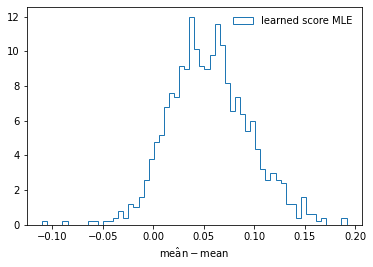

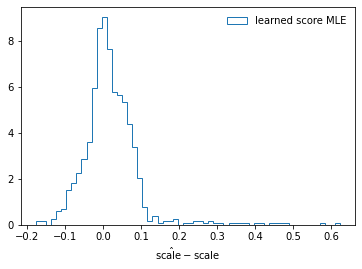

In [18]:
plt.hist(mle[:,0].numpy() - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\rm mean} - \rm{mean}$')
plt.legend(frameon=False)
plt.show()


plt.hist(mle[:,1].numpy() - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\rm scale} - \rm scale$')
plt.legend(frameon=False)
plt.show()

In [21]:
plt.scatter(theta[:10000, 0].numpy(), mle[:10000, 0].numpy(), s=1)

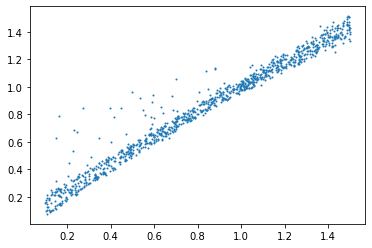

In [20]:
plt.scatter(theta[:10000, 1].numpy(), mle[:10000, 1].numpy(), s=1)